# EPIC220208795 - Period Analysis

This notebook contains all the steps necessary to check the ground-based survey data for additional eclipses or signs there of (with the same shape as the eclipse detected by <strong>K2</strong>). The work is quite extensive and intensive as we attempt period folding on ~20 years of photometric data from eight ground-based survey telescopes (ASAS, ASAS-SN, ATLAS and TESS) along with the <strong>K2</strong> data.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from Code import period_analysis as pa
from Code import ground_variation as gv

%matplotlib inline

## Load the Data

First we load all the photometric data, and then remove the stellar variation model from the data.

### TESS data

In [2]:
tess_data = np.loadtxt('epic2202_tess.txt')
tess_time, tess_flux, tess_err = tess_data[:,0], tess_data[:,1], tess_data[:,2]

#centering around BJD - 2457409
tess_time+=2457000
tess_time-=2457409

<Figure size 432x288 with 0 Axes>

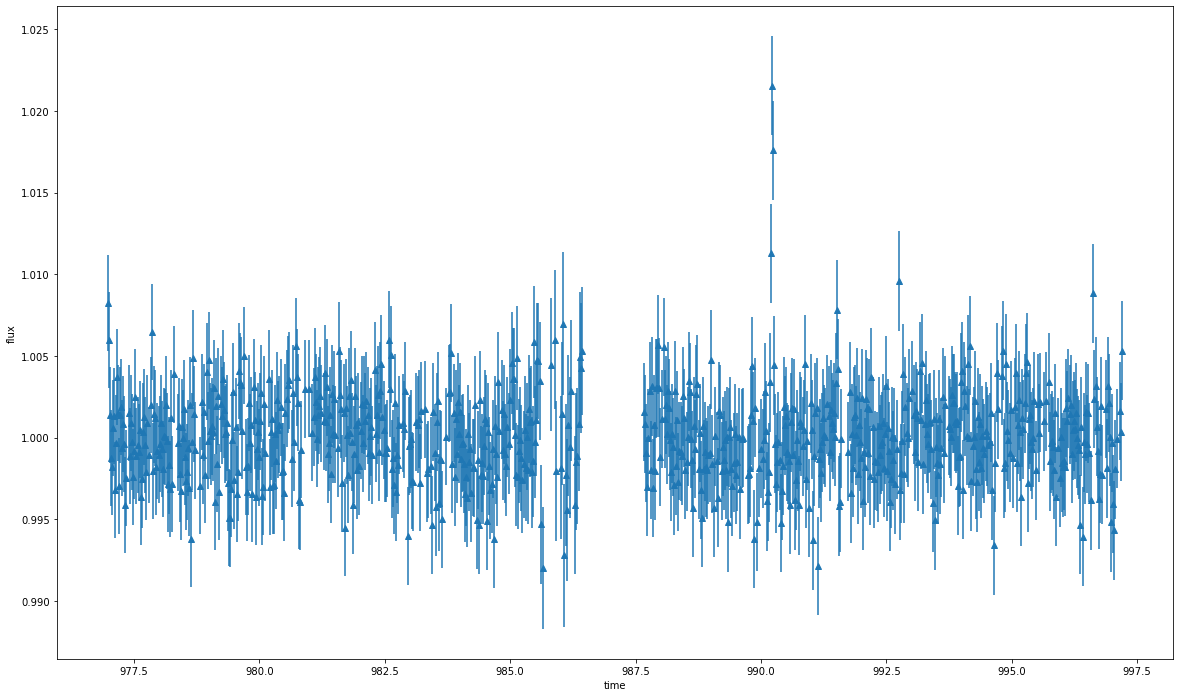

In [3]:
fig = plt.figure()
plt.figure(figsize=(20,12))
plt.xlabel('time')
plt.ylabel('flux')

# creating a mask to delete high errors and outliers
mask_errort = tess_err < 1
mask_fluxt = tess_flux > 0.2
mask_fluxt2 = tess_flux < 1.5
maskt = mask_fluxt * mask_fluxt2 * mask_errort
plt.errorbar(tess_time[maskt], tess_flux[maskt], yerr=tess_err[maskt], label='TESS', fmt='^')

plt.show()

In [4]:
## Plot parameters

SMALL_SIZE = 8*2                                        
MEDIUM_SIZE = 10*2
BIGGER_SIZE = 16*2

plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

### Ground based data

In [5]:
# load the data

from create_master_photometry import load_aavso
from create_master_photometry import magnitude_to_flux

times, fluxes, errors, airmasses, IDs = load_aavso('master_lightcurve.txt', flux=True)

#reset ASAS errorbars:
times_mag, mags, errors_mag, airmasses_mag, IDs_mag = load_aavso('master_lightcurve.txt', flux=False)

# ASAS 1I:
# Star is ~13.5 in I, hence we can just use estimate of the envelope of around 0.15 mag.
errors_mag[0] = np.sqrt(errors_mag[0]**2 + 0.15**2)

# ASAS 2V (all times above HJD 3200)
err_env_2v = 10**(-2.54-0.03218*mags[1] +0.0108*mags[1]**2)
errors_mag[1] = np.sqrt(errors_mag[1]**2 + err_env_2v**2)

# ASAS 4V
err_env_4v = 10**(1.1895-0.6382*mags[2] + 0.0343*mags[2]**2)
errors_mag[2] = np.sqrt(errors_mag[2]**2 + err_env_4v**2)

# ASAS 4V
err_env_4v = 10**(1.1895-0.6382*mags[2] + 0.0343*mags[2]**2)
errors_mag[2] = np.sqrt(errors_mag[2]**2 + err_env_4v**2)

# ASAS F0104+00_335 V
err_env_F = 10**(1.176-0.6705*mags[3] +0.0364*mags[3]**2)
errors_mag[3] = np.sqrt(errors_mag[3]**2 + err_env_F**2)

# convert back to flux
fluxes, errors = magnitude_to_flux(mags, errors_mag)

C:\Users\lvand\Downloads\Notebooks\BRP\EPIC2202\create_master_photometry.py:498: RuntimeWarning: overflow encountered in power
  flux_p = 10**((magnitude - magnitude_error) / -2.5)


<Figure size 576x432 with 0 Axes>

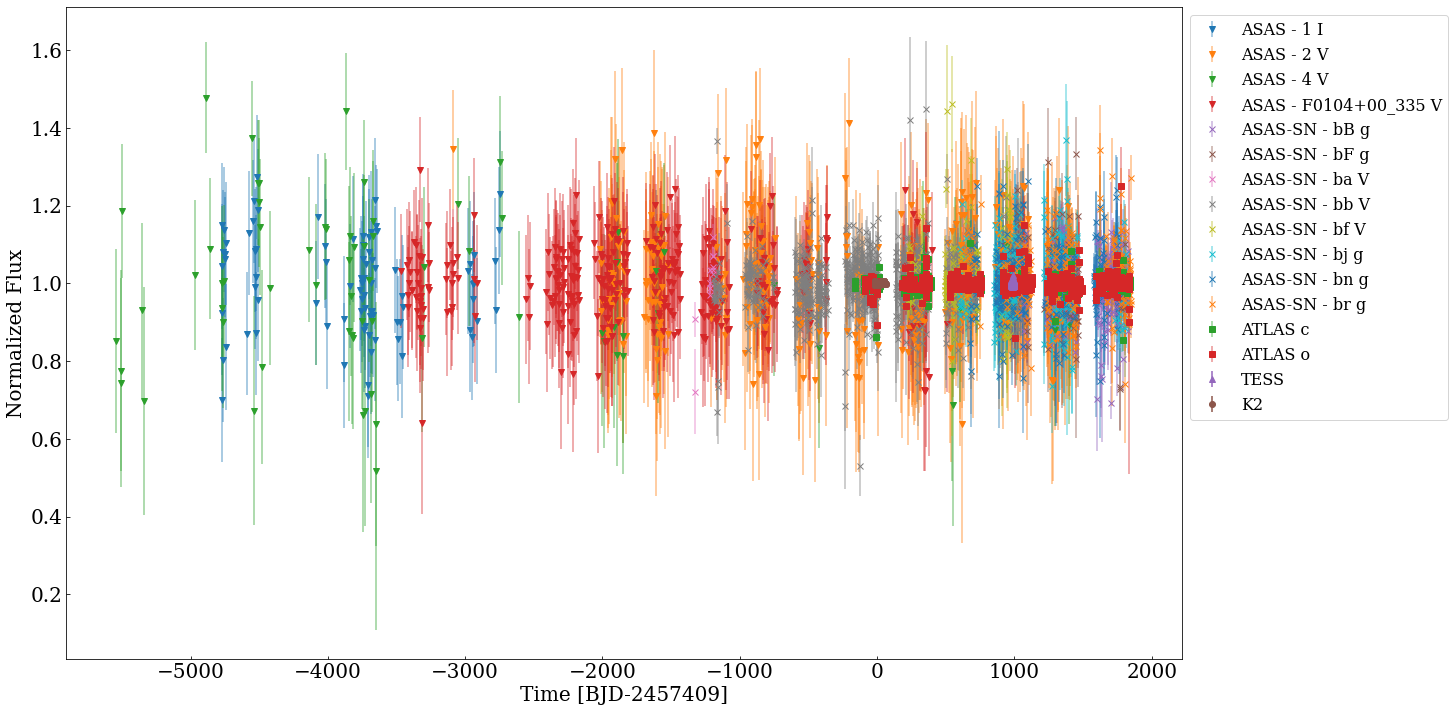

In [11]:
markers = (['v','v','v','v','x','x','x','x','x','x','x','x','s','s'])

# plot it

fig = plt.figure()
plt.figure(figsize=(20,12))
plt.xlabel('Time [BJD-2457409]')
plt.ylabel('Normalized Flux')
for time, flux, error, ID, marker, in zip(times, fluxes, errors, IDs, markers):
    mask_error = error < 1
    mask_flux = flux > 0.1
    mask_flux2 = flux < 1.5
    mask = mask_error * mask_flux * mask_flux2
    markers, caps, bars = plt.errorbar(time[mask]-2457409, flux[mask], yerr=error[mask], label=ID, fmt=marker)
    [bar.set_alpha(0.5) for bar in bars]
    [cap.set_alpha(0.5) for cap in caps]

mask_errort = tess_err < 1
mask_fluxt = tess_flux > 0.2
mask_fluxt2 = tess_flux < 1.5
maskt = mask_fluxt * mask_fluxt2 * mask_errort
plt.errorbar(tess_time[maskt], tess_flux[maskt], yerr=tess_err[maskt], label='TESS', fmt='^')
plt.errorbar(k2_time_full, k2_flux_full, yerr=k2_error_full, fmt='o', label='K2')

plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('groundbased.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Period Folding $-$ Preparation

Here we do the actual period folding and do some of the preparations necessary for it, like extracting K2 data from the rest, running a trial and then doing the period folding and making and saving the plots to be explored by hand.

### Extract K2 data and limits

In [7]:
ground_times = []
ground_fluxes = []
ground_errors = []
ground_IDs = []

#add mask

for time, flux, error, ID in zip(times, fluxes, errors, IDs):
    mask_error = error < 1
    mask_flux = flux > 0.2
    mask_flux2 = flux < 1.5
    mask = mask_error * mask_flux * mask_flux2
    ground_times.append(time[mask])
    ground_fluxes.append(flux[mask])
    ground_errors.append(error[mask])
    ground_IDs.append(ID)

In [8]:
# load in full lightcurve (without eclipse)
k2_time_full, k2_flux_full, k2_error_full = np.loadtxt('data 2202/everest_lightcurve2202.txt', skiprows=1).T
#centering around the eclipse
k2_time_full += 2454833
k2_time_full -= 2457409

# load in the eclipse
k2_time, k2_flux, k2_error = np.loadtxt('data 2202/everest_lightcurve2202_OLD.txt', skiprows=1).T
k2_time += 2454833

# creating a mask
mask_flux_k2 = k2_flux > 0.7
k2_time, k2_flux, k2_error = k2_time[mask_flux_k2], k2_flux[mask_flux_k2], k2_error[mask_flux_k2]


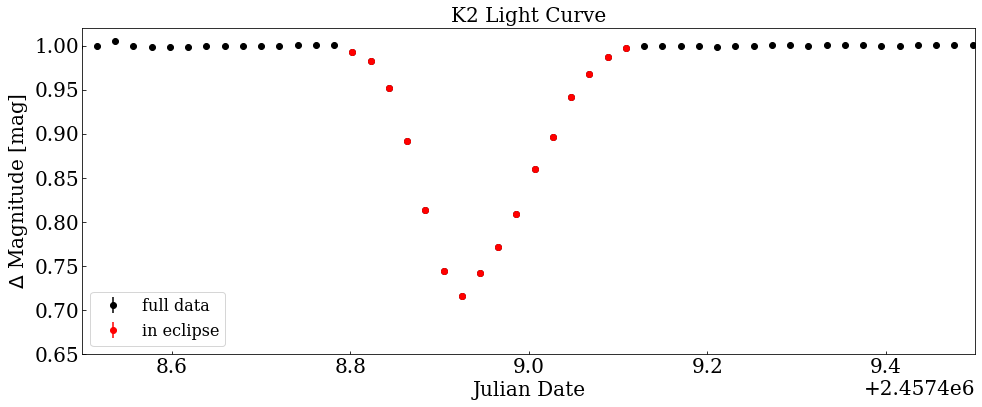

In [9]:
# get the eclipse
k2l = 810
k2u = 826
k2te = k2_time[k2l:k2u]
k2me = k2_flux[k2l:k2u]
k2ee = k2_error[k2l:k2u]

fig = plt.figure(figsize=(16, 6))
plt.errorbar(k2_time, k2_flux, yerr=k2_error, fmt='o', color='k', label='full data')
plt.errorbar(k2te, k2me, yerr=k2ee, fmt='o', color='r', label='in eclipse')
plt.legend()
plt.title('K2 Light Curve')
plt.xlabel('Julian Date')
plt.ylabel('$\Delta$ Magnitude [mag]')
#plt.gca().invert_yaxis()
plt.xlim(2575.5+2454833, 2576.5+2454833)
plt.ylim(0.65,1.02)
plt.show()

### Test

This is just to ensure everything is working and give a feel for what the goal is of the period folding.

In [12]:
# do a test
period = 290.230
k2l = 810
k2u = 826
good_pct = 90
sigma = 3
plot_data, total, percentage, chi2s, tot_chi2 = pa.prepare_data(period, k2_time, k2_flux, k2_error, ground_times, ground_fluxes, ground_errors, k2l, k2u, sigma)

C:\Users\lvand\Downloads\Notebooks\BRP\EPIC2202\Code\period_analysis.py:239: RuntimeWarning: invalid value encountered in double_scalars
  chi2s.append(chi2 / num)


0.004895897851664092


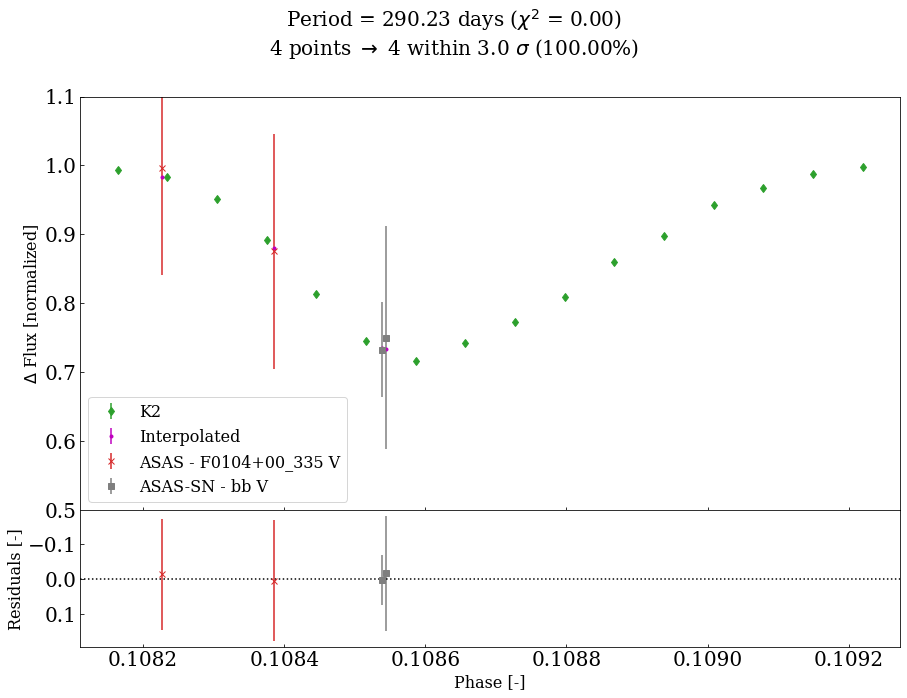

In [13]:
print(tot_chi2)

title_str = 'Period = %.2f days ($\chi^2$ = %.2f)\n%i points $\\rightarrow$ %i within %.1f $\sigma$ (%.2f%%)'
title = title_str % (period, tot_chi2, total, percentage*total/100, sigma, percentage)
pa.plot_folded_eclipse(*plot_data, ground_IDs, title=title, ylim1=(1.1,0.5))

## Period Folding $-$ Performing

Here we commit to the actual period folding itself. We know from the orbital analysis notebook that the period is limited between 66 days and $\sim$1200 days, so we choose this range, and choose a fine grid to test whether or not the period folding fulfills certain requirements.
- percentage of good points > outlier acceptance
    - good points lie within x times the error bar
    - outlier acceptance percentage is an input value
- we require there to be some data folded in
    - the number can be tuned

In [39]:
# folding periods in days
Pmin = 66    # min
Pmax = 1850  # max
dP   = 0.005 # step size (start large)
sr2 = 'plotsL/period_folding/sigma=%.1f_dP=0.01/'
sr3 = 'plotsL/period_folding/sigma=%.1f_dP=0.005/'

# combine
P = np.arange(Pmin, Pmax + dP, dP)

Prmin = 86
Prmax = 87
dPr = 0.001

Pr = np.arange(Prmin, Prmax + dPr, dPr)

In [40]:
# combining standard parameters
k2_params = (k2_time, k2_flux, k2_error)
ground_params = (ground_times, ground_fluxes, ground_errors, ground_IDs)

In [41]:
# plot parameters
xlim   = None
ylim1  = (1.1,0.5)
ylim2  = (-0.25, 0.25)
k2_ind = None
show   = False

# combine
plot_params = (xlim, ylim1, ylim2, k2_ind, show)

In [42]:
# defining parameters
k2_tl      = 809
k2_tu      = 826
good_pct   = 90
min_points = 5

### Unbinned Photometry

sigma = 3.0, good_percentage = 90 % and min_points = 5.

In [18]:
plot_selection_30 = (k2_tl, k2_tu, 3.0, good_pct, min_points)

# combine
full_params_30 = (*k2_params, *ground_params, *plot_selection_30, *plot_params)

# fold and extract
p_s30 = pa.fold_all(P, *full_params_30, saveroot=sr3)

text file exists -- done


sigma = 2.0, good_percentage = 90 % and min_points = 5.

In [14]:
# make new period array containing periods from above selection
Psig30 = np.loadtxt('plotsL/period_folding/sigma=3.0_dP=0.005/done.txt')
print(Psig30)

[  66.545   66.55    66.75  ... 1837.895 1837.9   1837.905]


In [15]:
# combine
plot_selection_20 = (k2_tl, k2_tu, 2.0, good_pct, min_points)
full_params_20 = (*k2_params, *ground_params, *plot_selection_20, *plot_params)

# folding and extracting
p_s20 = pa.fold_all(Psig30, *full_params_20, saveroot=sr3)

100%|██████████████████████████████████████████████████████████████████████████████| 5008/5008 [39:48<00:00,  2.10it/s]


removing text files
done


sigma = 1.5, good_percentage = 90 % and min_points = 5.

In [16]:
# make new period array containing periods from above selection
Psig20 = np.loadtxt('plotsL/period_folding/sigma=2.0_dP=0.005/done.txt')


In [17]:
# combine
plot_selection_15 = (k2_tl, k2_tu, 1.5, good_pct, min_points)
full_params_15 = (*k2_params, *ground_params, *plot_selection_15, *plot_params)

# folding and extracting
p_s15 = pa.fold_all(Psig20, *full_params_15, saveroot=sr3)

100%|██████████████████████████████████████████████████████████████████████████████| 1375/1375 [04:14<00:00,  5.41it/s]


removing text files
done


sigma = 1.0, good_percentage = 90 % and min_points = 5.

In [18]:
# make new period array containing periods from above selection
Psig15 = np.loadtxt('plotsL/period_folding/sigma=1.5_dP=0.005/done.txt')

In [19]:
# combine
plot_selection_10 = (k2_tl, k2_tu, 1.0, good_pct, min_points)
full_params_10 = (*k2_params, *ground_params, *plot_selection_10, *plot_params)

# folding
p_s10 = pa.fold_all(Psig15, *full_params_10, saveroot=sr3)

100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 17.97it/s]


removing text files
done


### Binned Photometry (0.1 day = 2.4 hours)

Here we explore the period folding, but also add the fact that the data is binned (0.1 day bins). We bin each telescope (except <strong>K2</strong>) and then repeat the process above.

In [20]:
binsize = 0.1
sr_01b = 'plotsL/period_folding/sigma=%.1f_bs=0.10/'
sr_01b2 = 'plotsL/period_folding/sigma=%.1f_bs=0.10_dP=0.01/'
sr_01b3 = 'plotsL/period_folding/sigma=%.1f_bs=0.10_dP=0.005/'
sr_01br = 'plotsL/period_folding/sigma=%.1f_bs=0.10_dP=0.01_range/'

# set-up lists
binned_times  = []
binned_fluxes   = []
binned_errors = []

for time, flux, error in zip(ground_times, ground_fluxes, ground_errors):
    # calculate
    binned_time, binned_flux, binned_error = gv.bin_telescope(time, flux, error, binsize)
    # append
    binned_times.append(binned_time)
    binned_fluxes.append(binned_flux)
    binned_errors.append(binned_error)

binned_params = (binned_times, binned_fluxes, binned_errors, ground_IDs)

sigma = 3.0, good_percentage = 90 % and min_points = 5.

In [21]:
# combine
full_params_30b = (*k2_params, *binned_params, *plot_selection_30, *plot_params)

# fold and extract
p_s30b = pa.fold_all(P, *full_params_30b, saveroot=sr_01b3)

100%|█████████████████████████████████████████████████████████████████████████| 356801/356801 [24:02<00:00, 247.43it/s]


removing text files
done


sigma = 2.0, good_percentage = 90 % and min_points = 5.

In [22]:
# combine
full_params_20b = (*k2_params, *binned_params, *plot_selection_20, *plot_params)

# fold and extract
p_s20b = pa.fold_all(p_s30b, *full_params_20b, saveroot=sr_01b3)

100%|████████████████████████████████████████████████████████████████████████████████| 431/431 [00:36<00:00, 11.73it/s]


removing text files
done


sigma = 1.5, good_percentage = 90 % and min_points = 5.

In [23]:
# combine
full_params_15b = (*k2_params, *binned_params, *plot_selection_15, *plot_params)

# fold and extract
p_s15b = pa.fold_all(p_s20b, *full_params_15b, saveroot=sr_01b3)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:26<00:00,  3.05it/s]

removing text files
done


sigma = 1.0, good_percentage = 90 % and min_points = 5.

In [24]:
# combine
full_params_10b = (*k2_params, *binned_params, *plot_selection_10, *plot_params)

# fold and extract
p_s10b = pa.fold_all(p_s15b, *full_params_10b, saveroot=sr_01b3)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.46it/s]

removing text files
done


### Binned Photometry (0.05 day $\sim$ 1 hours)

Here we explore the period folding, but also add the fact that the data is binned (0.05 day bins). We bin each telescope (except <strong>K2</strong>) and then repeat the process above.

In [25]:
binsize = 0.05
sr_005b = 'plotsL/period_folding/sigma=%.1f_bs=0.05/'
sr_005b2 = 'plotsL/period_folding/sigma=%.1f_bs=0.05_dP=0.01/'
sr_005b3 = 'plotsL/period_folding/sigma=%.1f_bs=0.05_dP=0.005/'

# set-up lists
binned_times  = []
binned_fluxes   = []
binned_errors = []

for time, flux, error in zip(ground_times, ground_fluxes, ground_errors):
    # calculate
    binned_time, binned_flux, binned_error = gv.bin_telescope(time, flux, error, binsize)
    # append
    binned_times.append(binned_time)
    binned_fluxes.append(binned_flux)
    binned_errors.append(binned_error)

binned_params = (binned_times, binned_fluxes, binned_errors, ground_IDs)

sigma = 3.0, good_percentage = 90 % and min_points = 5.

In [26]:
# fold and extract
p_s30b2 = pa.fold_all(P, *full_params_30b, saveroot=sr_005b3)

100%|█████████████████████████████████████████████████████████████████████████| 356801/356801 [17:38<00:00, 337.13it/s]


removing text files
done


sigma = 2.0, good_percentage = 90 % and min_points = 5.

In [27]:
# fold and extract
p_s20b2 = pa.fold_all(p_s30b2, *full_params_20b, saveroot=sr_005b3)

100%|████████████████████████████████████████████████████████████████████████████████| 431/431 [00:33<00:00, 12.78it/s]

removing text files
done


sigma = 1.5, good_percentage = 90 % and min_points = 5.

In [28]:
# fold and extract
p_s15b2 = pa.fold_all(p_s20b2, *full_params_15b, saveroot=sr_005b3)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:08<00:00,  9.89it/s]

removing text files
done


sigma = 1.0, good_percentage = 90 % and min_points = 5.

In [29]:
# fold
p_s10b2 = pa.fold_all(p_s15b2, *full_params_10b, saveroot=sr_005b3)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 11.92it/s]

removing text files
done


## Chi2 analysis

New chi2 function

In [43]:
def calc_chi2_comp(ground_mags, ground_errors, interp_mags):
    '''
    this function determines how many good and bad points there are
    AND compares it to a flat line
    
    Parameters
    ----------
    ground_mags : list of arrays
        contains the magnitude data (or flux) for each telescope
    ground_errors : list of arrays
        contains the error data for each telescope
    interp_mags : list of arrays
        contains the interpolated (to the eclispe) values of the magnitude
        data for each telescope
    
    Returns
    -------
    chi2s : array of floats
        contains the chi2 value for each telescope
    tot_chi2 : float
        contains the chi2 value for all the data combined
    chi2_flats : array of floats
        contains the chi2 value for each telescope comparing it to a flat line at 1
    tot_chi2_flat : float
        contains the chi2 value comparing it to a flat line for the data combined
    '''
    chi2s = []
    chi2_flats = [] #new
    tot_chi2 = 0
    tot_chi2_flat = 0 # new
    tot_num  = 0
    for gm, ge, im in zip(ground_mags, ground_errors, interp_mags):
        num = len(gm)
        chi2 = np.sum((gm - im)**2 / ge**2)
        chi2_flat = np.sum((gm - 1)**2 / ge**2) #new
        chi2s.append(chi2 / num)
        chi2_flats.append(chi2_flat / num)
        if num != 0:
            tot_chi2 += chi2
            tot_chi2_flat += chi2_flat
            tot_num  += num
    chi2s = np.array(chi2s)
    chi2_flats = np.array(chi2_flats) #new
    tot_chi2 /= tot_num
    tot_chi2_flat /= tot_num
    return tot_chi2, chi2s, tot_chi2_flat, chi2_flats #new

New prepare data function

In [44]:
def prepare_data_comp(period, k2_time, k2_mag, k2_error, ground_times, ground_mags,
               ground_errors, k2_tl, k2_tu, sigma):
    '''
    this function folds the photometry and creates the plot data in eclipse for
    plot_folded_eclipse(). It also reveals the total number of points, the 
    percentage of good points and the chi2 value for each telescope and all of
    them combined.

    Parameters
    ----------
    period : float
        value over which to fold the light curve
    k2_time : array of floats
        contains time data for K2
    k2_mag : array of floats
        contains magnitude data for K2
    k2_error : array of floats
        contains error data for K2
    ground_times : list of arrays
        contains time data for each telescope
    ground_mags : list of arrays
        contains magnitude data for each telescope
    ground_errors : list of arrays
        contains error data for each telescope
    k2_lt : int
        time index of the start of the eclipse (lower time limit)
    k2_ut : int
        time index of the end of the eclipse (upper time limit)
    sigma : float
        number of sigma deviations from the model considered acceptable

    Returns
    -------
    plot_data : tuple
        k2_pce : array of floats
            contains the corrected phases in eclipse for K2 data
        k2_me : array of floats
            contains the magnitudes in eclipse for K2 data
        k2_ee : array of floats
            contains the rrors in eclipse for K2 data
        ground_pces : list of arrays
            contains the corrected phases in eclipse for each telescope
        ground_mes : list of arrays
            contains the magnitudes in eclipse for each telescope
        ground_ees : list of arrays
            contains the errors in eclipse for each telescope
        ground_imgs : list of arrays
            contains the interpolated magnitudes in eclipse for each telescope
    total : int
        number of points in eclipse
    percentage : float
        percentage of points within sigma * error of the interpolated 
        eclipse value
    tot_chi2 : float
        chi2 value for all the folded data
    chi2s : array of floats
        the chi2 values of each telescope for the given period (note this is
        done by calc_chi2() --> chi2 = np.sum(((obs - exp) / err)**2) / num

    Notes
    -----
    k2_pce -- ground_imgs are grouped together as these are the inputs to the
    plot_folded_eclipse, the rest of the returns are separated
    '''
    # fold times to phases
    k2_phase       = pa.fold_light_curves(k2_time, period)[0]
    ground_phases  = pa.fold_light_curves(ground_times, period)
    # identify (p)hase limits (l)ower and (u)pper
    pl  = k2_phase[k2_tl]
    pu  = k2_phase[k2_tu - 1]
    # phases (p) corrected (c)
    k2_pc, ground_pcs, plc, puc = pa.correct_phase(k2_phase, ground_phases, pl, pu)
    # extract (e)clipse points
    eclipse = pa.extract_eclipse(k2_pc, k2_mag, k2_error, ground_pcs, ground_mags,
                              ground_errors, pl, pu)
    k2_pce, k2_me, k2_ee, ground_pces, ground_mes, ground_ees = eclipse
    # (i)nterpolate the ground (m)agnitudes to the eclipse and get statistics
    try:
        interp  = pa.interpolate_eclipse(ground_pces, ground_mes, ground_ees, 
                                      k2_pce, k2_me, sigma)
        ground_ims, total, percentage = interp
        tot_chi2, chi2s, tot_chi2_flat, chi2_flats = calc_chi2_comp(ground_mes, ground_ees, ground_ims) #new
    except:
        ground_ims = np.zeros_like(ground_mes)
        total = percentage = tot_chi2 = tot_chi2_flat = 0
        chi2s = np.zeros(len(ground_pces))
        chi2_flats = np.zeros(len(ground_pces))
    plot_data = (k2_pce, k2_me, k2_ee, ground_pces, ground_mes, ground_ees, 
                 ground_ims)
    return plot_data, total, percentage, tot_chi2, chi2s, tot_chi2_flat, chi2_flats #new

New folding function

In [45]:
def fold_all_comp(P_array, k2_time, k2_mag, k2_error, ground_times, ground_mags, 
             ground_errors, ground_tels, k2_lt, k2_ut, sigma, good_pct=90, 
             min_points=5, xlim=None, ylim1=None, ylim2=None, k2_ind=12,
             show=False, saveroot='plotsL/period_folding_comp/sigma=%.1f/', 
             savebase='chir=%03.3f_p=%.3f_n=%i.png', savenot='p=%.3f_n=0.txt', reset=False):
    '''
    this function folds the photometry and plots the data during the eclipse
    it considers what sigma * error is considered acceptable, what the minimum
    acceptance percentage to plot and how many points must be in eclipse (to
    prevent a lots of plots with just e.g. 1 point in eclipse. If no plot is
    made then a text file (containing a 0) is saved so that progress can be
    saved. when finished a "done.txt" file is saved and all other txt files are
    removed from the directory.
    
    Parameters
    ----------
    P_array : array of floats
        list of periods to fold
    k2_time : array of floats
        contains time data for K2
    k2_mag : array of floats
        contains magnitude data for K2
    k2_error : array of floats
        contains error data for K2
    ground_times : list of arrays
        contains time data for each telescope
    ground_mags : list of arrays
        contains magnitude data for each telescope
    ground_errors : list of arrays
        contains error data for each telescope
    ground_tels : list of str
        contains the names of the ground-based telescopes
    k2_lt : int
        time index of the start of the eclipse (lower time limit)
    k2_ut : int
        time index of the end of the eclipse (upper time limit)
    sigma : float
        number of sigma deviations from the model considered acceptable
    good_pct : float
        percantage of good points that is accepted
    min_points : int
        minimum number of points in eclipse to make a plot
    xlim : tuple
        x-axis limits of the plot
    ylim1 : tuple
        y-axis limits of the photometry plot
    ylim2 : tuple
        y-axis limits of the residual plot
    k2_ind : int
        index of the K2 data in all telescope data (to ensure proper colors and
        markers)
    show : bool
        if true then the plot will be shown
    saveroot : str
        name of the directory structure where all the plots will be saved
    savebase : str
        name of the plot structure
    savenot : str
        name of the no plot structure (if no plot is done then save a txt file)

    Returns
    -------
    good_periods : array of floats
        array containing all the periods that produce a plot

    Notes
    -----
    this function produces lots of figures and a txt file called done that
    contains good_periods and is used to check whether any periods need to be
    folded at all
    '''
    # create parameters
    params = (k2_time, k2_mag, k2_error, ground_times, ground_mags, 
              ground_errors, k2_lt, k2_ut)
    title_top = 'Period = %.3f days ($\chi^2$ = %.2f) ($\chi^2_{flat}$ = %.2f)\n'
    title_bot = '%i points $\\rightarrow$ %i within %.1f $\sigma$ (%.2f%%)'
    title_str = title_top + title_bot
    savedir   = saveroot % sigma
    totalsave = saveroot + savebase
    totalnot  = saveroot + savenot
    chi2s = []
    chi2_flats = []
    # check whether directory exists and determine which files are done
    if not os.path.exists(savedir):
        os.mkdir(savedir)
        done = ''
    else:
        done = ','.join(os.listdir(savedir))
    # if done.txt is present in directory quit
    if os.path.exists(savedir + '/done.txt'):
        if reset == False:
            print('text file exists -- done')
            good_periods, cm = np.loadtxt(savedir + '/done.txt', delimiter=',')
            return good_periods, cm
        else:
            os.remove(savedir + '/done.txt')
    # else start period folding
    for p in tqdm(P_array):
        if ('p=%.3f' % p) in done:
            continue
        data, total, pct, chi2_tot, chi2, chi2_flat_tot, chi2_flat = prepare_data_comp(p, *params, sigma)
        if (pct >= good_pct) and (total >= min_points) and (chi2_flat_tot/chi2_tot > 10):      #new
            title = title_str % (p, chi2_tot, chi2_flat_tot, total, pct*total/100, sigma, pct)
            cm = chi2_flat_tot/chi2_tot
            save = totalsave % (sigma, cm, p, total)
            pa.plot_folded_eclipse(*data, ground_tels, xlim, ylim1, ylim2, title, save, show, k2_ind)
            chi2s.append(chi2_tot) #new
            chi2_flats.append(chi2_flat_tot) #new
        else:
            save = totalnot % (sigma, p)
            np.savetxt(save, [0])
    # remove txt files
    print('removing text files')
    files = os.listdir(savedir)
    for f in files:
        name, ext = os.path.splitext(f)
        if ext == '.txt':
            os.remove(savedir + f)
    # construct good_periods
    good_periods = []
    files = os.listdir(savedir)
    for f in files:
        try:
            p = f.split('_')[1]
            period = float(p.split('=')[-1])
            good_periods.append(period)
        except:
            pass
    chi2s = np.array(chi2s) #new
    chi2_flats = np.array(chi2_flats) #new
    good_periods = np.sort(np.array(good_periods))
    savedone = savedir + '/done.txt'
    np.savetxt(savedone, np.column_stack((good_periods, chi2_flats/chi2s)), fmt='%.3f', delimiter=',')
    print('done')
    return good_periods, chi2s, chi2_flats

## Folding

In [46]:
# folding periods in days
Pmin = 66    # min
Pmax = 1850  # max2 previously 6613
dP   = 0.01 # step size (start large)

# combine
P = np.arange(Pmin, Pmax + dP, dP)

In [47]:
# defining parameters
k2_tl      = 813
k2_tu      = 829
good_pct   = 90
min_points = 3 # new!

3 sigma test, minimum 3 points dP = 0.01

In [48]:
plot_selection_30 = (k2_tl, k2_tu, 3.0, good_pct, min_points)

# combine
full_params_30 = (*k2_params, *ground_params, *plot_selection_30, *plot_params)

# fold and extract
#p_s30, chi2_30, chi2_flats_30 = fold_all_comp(P, *full_params_30, saveroot='plotsL/period_folding_comp/sigma=%.1f_dP=0.01_sorted_ab10/')
p_s30, cm_30 = fold_all_comp(P, *full_params_30, saveroot='plotsL/period_folding_comp/sigma=%.1f_dP=0.01_sorted_ab10/')

text file exists -- done


ValueError: too many values to unpack (expected 2)

In [49]:
# construct good_periods
"""good_periods = []
files = os.listdir('plotsL/period_folding_comp/sigma=3.0/')
for f in files:
    try:
        p = f.split('_')[0]
        period = float(p.split('=')[-1])
        good_periods.append(period)
    except:
        pass
p_s30 = np.sort(np.array(good_periods))
print(len(p_s30))"""

"good_periods = []\nfiles = os.listdir('plotsL/period_folding_comp/sigma=3.0/')\nfor f in files:\n    try:\n        p = f.split('_')[0]\n        period = float(p.split('=')[-1])\n        good_periods.append(period)\n    except:\n        pass\np_s30 = np.sort(np.array(good_periods))\nprint(len(p_s30))"

In [50]:
plt.bar(p_s30, chi2_flats_30/chi2_30, width=10)
plt.plot(p_s30, chi2_flats_30/chi2_30, "k.")
plt.xlabel('Period (days)')
plt.ylabel('$\chi^2_{flat}$/$\chi^2$')
plt.title('Chi squared versus periods')
#plt.ylim(0,3)
#plt.xlim(1230,1240)

NameError: name 'p_s30' is not defined

## dP = 0.005

In [51]:
Pmin = 66    # min
Pmax = 1850  # max2 previously 6613
dP2   = 0.005 # step size (start large)

# combine
P2 = np.arange(Pmin, Pmax + dP2, dP2)

In [52]:
plot_selection_30 = (k2_tl, k2_tu, 3.0, good_pct, min_points)

# combine
full_params_30 = (*k2_params, *ground_params, *plot_selection_30, *plot_params)

# fold and extract
p_s30_2, chi2_30_2, chi2_flats_30_2 = fold_all_comp(P2, *full_params_30, saveroot='plotsL/period_folding_comp/sigma=%.1f_dP=0.005_sorted_ab10/')

text file exists -- done


ValueError: too many values to unpack (expected 2)

In [53]:
plt.bar(p_s30_2, chi2_flats_30_2/chi2_30_2, width=10)
plt.plot(p_s30_2, chi2_flats_30_2/chi2_30_2, "k.")
plt.xlabel('Period (days)')
plt.ylabel('$\chi^2_{flat}$/$\chi^2$')
plt.title('Chi squared versus periods')
#plt.ylim(0,3)
#plt.xlim(1230,1240)

NameError: name 'p_s30_2' is not defined

## dP = 0.001

In [273]:
Pmin = 66    # min
Pmax = 1850  # max2 previously 6613
dP3   = 0.001 # step size (start large)

# combine
P3 = np.arange(Pmin, Pmax + dP3, dP3)

In [274]:
plot_selection_30 = (k2_tl, k2_tu, 3.0, good_pct, min_points)

# combine
full_params_30 = (*k2_params, *ground_params, *plot_selection_30, *plot_params)

# fold and extract
p_s30_3, chi2_30_3, chi2_flats_30_3 = fold_all_comp(P3, *full_params_30, saveroot='plotsL/period_folding_comp/sigma=%.1f_dP=0.001_sorted_ab10/')

  0%|                                                                                      | 0/1784001 [00:00<?, ?it/s]C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
100%|█████████████████████████████████████████████████████████████████████| 1784001/1784001 [2:35:13<00:00, 191.54it/s]


removing text files
done


Text(0.5, 1.0, 'Chi squared versus periods')

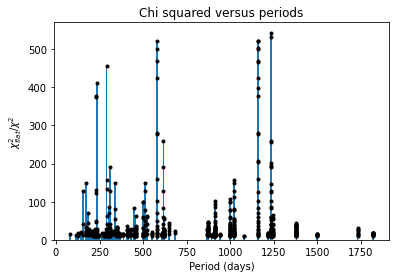

In [275]:
plt.bar(p_s30_3, chi2_flats_30_3/chi2_30_3, width=10)
plt.plot(p_s30_3, chi2_flats_30_3/chi2_30_3, "k.")
plt.xlabel('Period (days)')
plt.ylabel('$\chi^2_{flat}$/$\chi^2$')
plt.title('Chi squared versus periods')
#plt.ylim(0,3)
#plt.xlim(1230,1240)

## FILTER

In [19]:
# defining parameters (eclipse)
k2_tl_ecl      = 813
k2_tu_ecl      = 820
good_pct_ecl   = 90
min_points_ecl = 1 

## dP = 0.01

In [262]:
plot_selection_30_ecl = (k2_tl_ecl, k2_tu_ecl, 3.0, good_pct_ecl, min_points_ecl)

# combine
full_params_30_ecl = (*k2_params, *ground_params, *plot_selection_30_ecl, *plot_params)

# fold and extract
p_s30_ecl, chi2_30_ecl, chi2_flats_30_ecl = fold_all_comp(p_s30, *full_params_30_ecl)

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.26it/s]

removing text files
done


In [263]:
ok_period = []
ok_chi2 = []
ok_chi2_flat = []
good_chi2 = []
good_chi2_flat = []
for p, c2, c2f in zip(p_s30, chi2_30, chi2_flats_30):
        if p in p_s30_ecl:
                good_chi2.append(c2)
                good_chi2_flat.append(c2f)
        else:
                ok_period.append(p)
                ok_chi2.append(c2)
                ok_chi2_flat.append(c2f)
ok_c2r = np.array(ok_chi2_flat)/np.array(ok_chi2)
good_c2r = np.array(good_chi2_flat)/np.array(good_chi2)

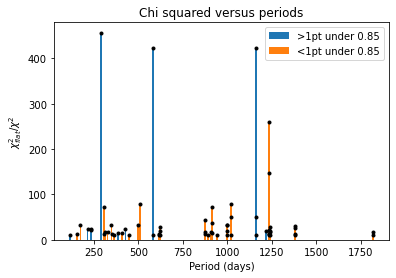

In [264]:
plt.bar(p_s30_ecl, good_c2r, width=10, label='>1pt under 0.85')
plt.plot(p_s30_ecl, good_c2r, "k.")
plt.bar(ok_period, ok_c2r, width=10, label='<1pt under 0.85')
plt.plot(ok_period, ok_c2r, "k.")
plt.xlabel('Period (days)')
plt.ylabel('$\chi^2_{flat}$/$\chi^2$')
plt.title('Chi squared versus periods')
plt.legend()

## dP = 0.005

In [267]:
plot_selection_30_ecl = (k2_tl_ecl, k2_tu_ecl, 3.0, good_pct_ecl, min_points_ecl)

# combine
full_params_30_ecl = (*k2_params, *ground_params, *plot_selection_30_ecl, *plot_params)

# fold and extract
p_s30_ecl_2, chi2_30_ecl_2, chi2_flats_30_ecl_2 = fold_all_comp(p_s30_2, *full_params_30_ecl)

  0%|                                                                                          | 0/127 [00:00<?, ?it/s]C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:14<00:00,  8.53it/s]

removing text files
done


In [271]:
ok_period_2 = []
ok_chi2_2 = []
ok_chi2_flat_2 = []
good_chi2_2 = []
good_chi2_flat_2 = []
for p, c2, c2f in zip(p_s30_2, chi2_30_2, chi2_flats_30_2):
        if p in p_s30_ecl_2:
                good_chi2_2.append(c2)
                good_chi2_flat_2.append(c2f)
        else:
                ok_period_2.append(p)
                ok_chi2_2.append(c2)
                ok_chi2_flat_2.append(c2f)
ok_c2r_2 = np.array(ok_chi2_flat_2)/np.array(ok_chi2_2)
good_c2r_2 = np.array(good_chi2_flat_2)/np.array(good_chi2_2)

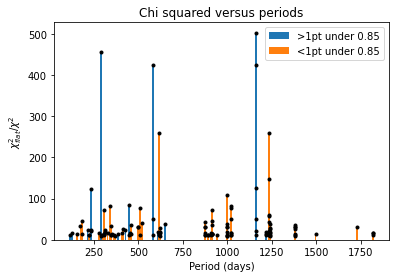

In [272]:
plt.bar(p_s30_ecl_2, good_c2r_2, width=10, label='>1pt under 0.85')
plt.plot(p_s30_ecl_2, good_c2r_2, "k.")
plt.bar(ok_period_2, ok_c2r_2, width=10, label='<1pt under 0.85')
plt.plot(ok_period_2, ok_c2r_2, "k.")
plt.xlabel('Period (days)')
plt.ylabel('$\chi^2_{flat}$/$\chi^2$')
plt.title('Chi squared versus periods')
plt.legend()

## dP = 0.001

In [276]:
# fold and extract
p_s30_ecl_3, chi2_30_ecl_3, chi2_flats_30_ecl_3 = fold_all_comp(p_s30_3, *full_params_30_ecl)

  0%|                                                                                          | 0/647 [00:00<?, ?it/s]C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lvand\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
100%|████████████████████████████████████████████████████████████████████████████████| 647/647 [01:35<00:00,  6.77it/s]


removing text files
done


In [277]:
ok_period_3 = []
ok_chi2_3 = []
ok_chi2_flat_3 = []
good_chi2_3 = []
good_chi2_flat_3 = []
for p, c2, c2f in zip(p_s30_3, chi2_30_3, chi2_flats_30_3):
        if p in p_s30_ecl_3:
                good_chi2_3.append(c2)
                good_chi2_flat_3.append(c2f)
        else:
                ok_period_3.append(p)
                ok_chi2_3.append(c2)
                ok_chi2_flat_3.append(c2f)
ok_c2r_3 = np.array(ok_chi2_flat_3)/np.array(ok_chi2_3)
good_c2r_3 = np.array(good_chi2_flat_3)/np.array(good_chi2_3)

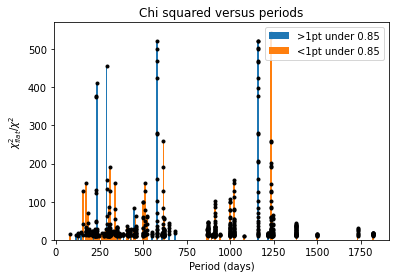

In [278]:
plt.bar(p_s30_ecl_3, good_c2r_3, width=10, label='>1pt under 0.85')
plt.plot(p_s30_ecl_3, good_c2r_3, "k.")
plt.bar(ok_period_3, ok_c2r_3, width=10, label='<1pt under 0.85')
plt.plot(ok_period_3, ok_c2r_3, "k.")
plt.xlabel('Period (days)')
plt.ylabel('$\chi^2_{flat}$/$\chi^2$')
plt.title('Chi squared versus periods')
plt.savefig('chi2comparison.pdf', format='pdf')
plt.legend(loc='lower right')